# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os

# Loading data and select features

## Import Data

In [2]:
# Set data path for Kaggle
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
    loan_data_preprocessed_backup = pd.read_csv('/kaggle/input/creditrisk-train-test/loan_data_2007_2014_preprocessed.csv', index_col=0)
else:
    loan_data_preprocessed_backup = pd.read_csv('../data/loan_data_2007_2014_preprocessed.csv', index_col=0)

/tmp/ipykernel_103534/2784625602.py:5: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('../data/loan_data_2007_2014_preprocessed.csv', index_col=0)


## Explore Data

In [3]:
loan_data_preprocessed = loan_data_preprocessed_backup

In [4]:
loan_data_preprocessed.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,0,0,0,0,0,0,0,1,0,1
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,0,0,0,0,0,0,1,0,0
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,0,0,0,0,0,0,1,0,1
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,0,0,0,0,0,0,1,0,1
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,0,0,0,0,0,0,1,0,1


Modeling for the account status `Default` not recommended since at default the client still have time to pay and recover.  
Then select account status  `charge of`. 

In [5]:
loan_data_preprocessed["loan_status"].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [6]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed["loan_status"].isin(["Charged Off", 
                                                                                        "Does not meet the credit policy. Status:Charged Off'"])]

In [7]:
loan_data_defaults.shape

(42475, 208)

In [8]:
loan_data_preprocessed.isna().sum()[loan_data_defaults.isna().sum() > 1]

emp_title                       27588
emp_length                      21008
desc                           340304
title                              21
mths_since_last_delinq         250351
mths_since_last_record         403647
revol_util                        340
last_pymnt_d                      376
next_pymnt_d                   227214
last_credit_pull_d                 42
collections_12_mths_ex_med        145
mths_since_last_major_derog    367311
annual_inc_joint               466285
dti_joint                      466285
verification_status_joint      466285
tot_coll_amt                    70276
tot_cur_bal                     70276
open_acc_6m                    466285
open_il_6m                     466285
open_il_12m                    466285
open_il_24m                    466285
mths_since_rcnt_il             466285
total_bal_il                   466285
il_util                        466285
open_rv_12m                    466285
open_rv_24m                    466285
max_bal_bc  

The LGD , EAD model need not to be comprehensible , then no need to do fine classing & Woe for categorical variable.  
And continuous variable use as it is.  

In [9]:
loan_data_defaults = loan_data_defaults.fillna({"mths_since_last_delinq":0, "mths_since_last_record":0})

## Dependence variable

In [10]:
loan_data_defaults["recovery_rate"] = loan_data_defaults["recoveries"] / loan_data_defaults["funded_amnt"]

In [11]:
loan_data_defaults["recovery_rate"].describe()

count    42475.000000
mean         0.060802
std          0.088033
min          0.000000
25%          0.000000
50%          0.030302
75%          0.114715
max          1.220774
Name: recovery_rate, dtype: float64

In [12]:
loan_data_defaults["recovery_rate"] = np.select([loan_data_defaults["recovery_rate"] > 1,
                                                 loan_data_defaults["recovery_rate"] < 0],
                                                [1, 
                                                 0],
                                                default=loan_data_defaults["recovery_rate"])                                                

In [13]:
loan_data_defaults["recovery_rate"].describe()

count    42475.000000
mean         0.060763
std          0.087586
min          0.000000
25%          0.000000
50%          0.030302
75%          0.114715
max          1.000000
Name: recovery_rate, dtype: float64

Credit conversion factor (CCF) = Exposure at default = amount unpaided / total funded amt

In [14]:
loan_data_defaults["CCF"] = (loan_data_defaults["funded_amnt"] - loan_data_defaults["total_rec_prncp"])/loan_data_defaults["funded_amnt"]

In [15]:
loan_data_defaults["CCF"].describe()

count    42475.000000
mean         0.737033
std          0.199849
min          0.000438
25%          0.634095
50%          0.790682
75%          0.888871
max          1.000000
Name: CCF, dtype: float64

## Explore Dependenct Variables

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style()

(array([2.065e+04, 1.654e+03, 3.767e+03, 1.386e+03, 2.129e+03, 3.336e+03,
        4.757e+03, 1.710e+03, 1.173e+03, 3.990e+02, 3.360e+02, 2.740e+02,
        1.100e+02, 9.100e+01, 8.100e+01, 7.200e+01, 5.400e+01, 6.900e+01,
        5.400e+01, 2.700e+01, 4.400e+01, 2.700e+01, 1.600e+01, 1.500e+01,
        1.900e+01, 2.200e+01, 1.700e+01, 7.000e+00, 9.000e+00, 6.000e+00,
        8.000e+00, 6.000e+00, 7.000e+00, 6.000e+00, 5.000e+00, 9.000e+00,
        4.000e+00, 1.000e+01, 8.000e+00, 9.000e+00, 4.000e+00, 6.000e+00,
        6.000e+00, 3.000e+00, 8.000e+00, 7.000e+00, 1.400e+01, 7.000e+00,
        8.000e+00, 2.900e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 

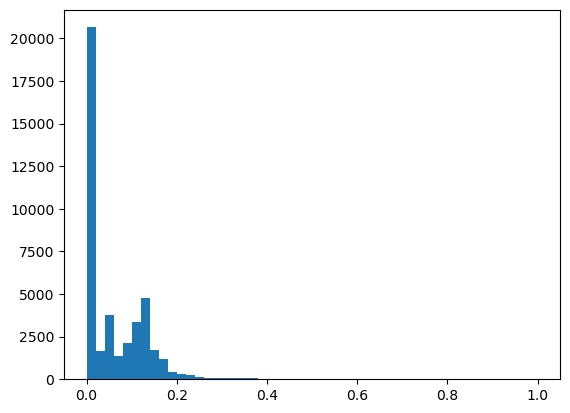

In [17]:
plt.hist(loan_data_defaults["recovery_rate"], bins=50)

(array([  19.,   58.,   29.,   92.,   67.,   80.,  144.,   75.,  121.,
         168.,  145.,  202.,  187.,  219.,  230.,  267.,  296.,  318.,
         328.,  362.,  400.,  414.,  497.,  493.,  567.,  573.,  605.,
         716.,  746.,  793.,  819.,  920.,  938., 1121., 1195., 1396.,
        1404., 1559., 1704., 1824., 1964., 2130., 2106., 2345., 2420.,
        2654., 2328., 2081., 1496.,  860.]),
 array([4.3800000e-04, 2.0429240e-02, 4.0420480e-02, 6.0411720e-02,
        8.0402960e-02, 1.0039420e-01, 1.2038544e-01, 1.4037668e-01,
        1.6036792e-01, 1.8035916e-01, 2.0035040e-01, 2.2034164e-01,
        2.4033288e-01, 2.6032412e-01, 2.8031536e-01, 3.0030660e-01,
        3.2029784e-01, 3.4028908e-01, 3.6028032e-01, 3.8027156e-01,
        4.0026280e-01, 4.2025404e-01, 4.4024528e-01, 4.6023652e-01,
        4.8022776e-01, 5.0021900e-01, 5.2021024e-01, 5.4020148e-01,
        5.6019272e-01, 5.8018396e-01, 6.0017520e-01, 6.2016644e-01,
        6.4015768e-01, 6.6014892e-01, 6.8014016e-01, 7.0

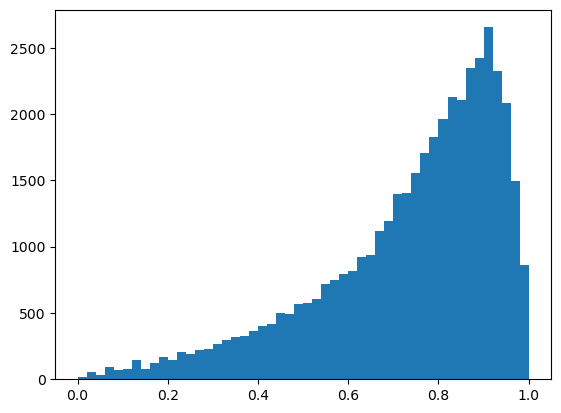

In [18]:
plt.hist(loan_data_defaults["CCF"], bins=50)

In [19]:
loan_data_defaults["recovery_rate_0_1"] = np.where(loan_data_defaults["recovery_rate"] == 0, 0, 1)
loan_data_defaults["recovery_rate_0_1"]

1         1
8         1
9         1
12        1
14        1
         ..
466254    0
466256    0
466276    1
466277    0
466281    0
Name: recovery_rate_0_1, Length: 42475, dtype: int64

# LGD model

## Splitting data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(["good_bad", "recovery_rate", "recovery_rate_0_1", "CCF"], axis="columns"), loan_data_defaults["recovery_rate_0_1"], test_size=0.2, random_state=42)

## Preparing the inputs

In [22]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']
# List of all independent variables for the models.

In [23]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']
# List of the dummy variable reference categories. 

In [24]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis="columns")

## Estimating The model

In [25]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(np.array(F_ij, dtype='float64'))
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [26]:
reg_lgd_st_1 = LogisticRegression_with_p_values()
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

/home/danny/miniconda3/envs/dask/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
reg_lgd_st_1.model.feature_names_in_

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [28]:
feature_name = lgd_inputs_stage_1_train.columns

In [29]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = reg_lgd_st_1.coef_.transpose()
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()

p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan, np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.660598e-04,NaN
1,grade:A,-3.646445e-05,9.996720e-01
2,grade:B,-1.885507e-04,9.978983e-01
3,grade:C,-2.299985e-04,9.973202e-01
4,grade:D,-5.663094e-06,9.999361e-01
5,grade:E,4.320904e-05,9.995562e-01
6,grade:F,1.343052e-04,9.988009e-01
7,home_ownership:MORTGAGE,-1.327272e-04,9.958853e-01
8,home_ownership:NONE,1.944267e-06,9.999980e-01
9,home_ownership:OTHER,1.151307e-06,9.999982e-01


## Test the model

In [30]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis="columns")

In [31]:
lgd_inputs_stage_1_test.columns

Index(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase',
       'purpose:medical', 'purpose:moving', 'purpose:other',
       'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding', 'initial_list_status:w',
       'term_int', 'emp_length_int', 'mths_since_issue_d',
       'mths_since_earliest_cr_line', 'funded_amnt', 'int_rate', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'total_acc', 'acc_now_delinq', 'total_rev_hi_lim'],
      dtype='object')

In [32]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [33]:
y_hat_test_lgd_stage_1

array([1, 0, 1, ..., 1, 1, 0])

In [34]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [35]:
y_hat_test_proba_lgd_stage_1[:, [1]].shape

(8495, 1)

In [36]:
y_hat_test_proba_lgd_stage_1[:, 1].shape

(8495,)

In [37]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[:][: , 1]
# equivalant command convert MxN - > 1D array
# y_hat_test_proba_lgd_stage_1[:, 1]

In [38]:
y_hat_test_proba_lgd_stage_1

array([0.61951654, 0.30942016, 0.68572839, ..., 0.51010723, 0.54587668,
       0.48388439])

In [39]:
y_hat_test_proba_lgd_stage_1.shape

(8495,)

In [40]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [41]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace=True)

In [42]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis="columns")

In [43]:
df_actual_predicted_probs.columns = ["lgd_targets_stage_1_test", "y_hat_test_proba_lgd_stage_1"]

In [44]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [45]:
df_actual_predicted_probs

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
88068,1,0.619517
340018,0,0.309420
3816,0,0.685728
29236,0,0.767133
109278,1,0.619273
...,...,...
75210,0,0.544232
154437,1,0.498729
375491,0,0.510107
221720,1,0.545877


## Estimating the Accuracy of the Model

In [46]:
tr = 0.5
df_actual_predicted_probs["y_hat_test_lgd_stage_1"] = np.where(df_actual_predicted_probs["y_hat_test_proba_lgd_stage_1"] > tr, 1, 0)

In [47]:
pd.crosstab(df_actual_predicted_probs["lgd_targets_stage_1_test"], df_actual_predicted_probs["y_hat_test_lgd_stage_1"], rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,1299,2399
1,876,3921


In [48]:
from sklearn.metrics import roc_auc_score, roc_curve

In [49]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs["lgd_targets_stage_1_test"], df_actual_predicted_probs["y_hat_test_lgd_stage_1"])

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

Text(0.5, 1.0, 'ROC Curve')

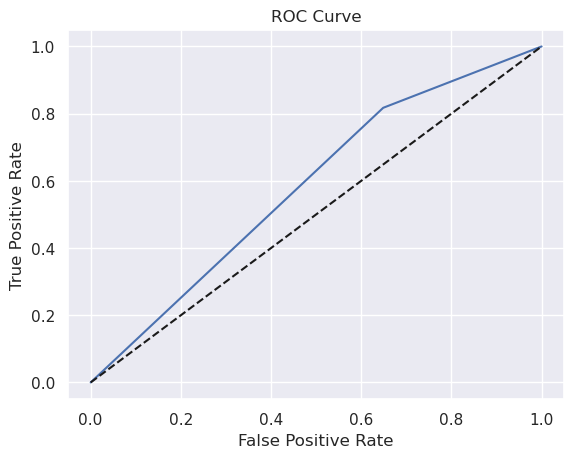

In [51]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle="--", color="k")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [52]:
AUROC = roc_auc_score(df_actual_predicted_probs["lgd_targets_stage_1_test"], df_actual_predicted_probs["y_hat_test_proba_lgd_stage_1"])
AUROC

0.6578960304309537

## Save the model

In [53]:
import pickle
pickle.dump(reg_lgd_st_1, open("../data/lgd_model_stage_1.sav", "wb"))

## LGD : stage 2 - Liner Regression

In [54]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults["recovery_rate_0_1"] == 1]

In [55]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(["good_bad", "recovery_rate", "recovery_rate_0_1", "CCF"], axis="columns"), lgd_stage_2_data["recovery_rate"], test_size=0.2, random_state=42)

In [56]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        super().__init__(fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs)
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [58]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [59]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [60]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

In [61]:
feature_name = lgd_inputs_stage_2_train.columns.values


In [62]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.264341e-01,NaN
1,grade:A,-4.815164e-02,0.000
2,grade:B,-3.688998e-02,0.000
3,grade:C,-2.532823e-02,0.000
4,grade:D,-1.739225e-02,0.000
5,grade:E,-6.432096e-03,0.126
6,grade:F,-1.451865e-03,0.761
7,home_ownership:MORTGAGE,3.681100e-03,0.011
8,home_ownership:NONE,2.727074e-01,0.000
9,home_ownership:OTHER,-4.963639e-03,0.831


## LGD : stage 2 - Liner Regression Evaluation

In [63]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]
# Here we keep only the variables we need for the model.

In [64]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [65]:
lgd_inputs_stage_2_test.columns.values
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [66]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [67]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [68]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [69]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,recovery_rate,0
recovery_rate,1.000000,0.318349
0,0.318349,1.000000


<Axes: xlabel='recovery_rate', ylabel='Count'>

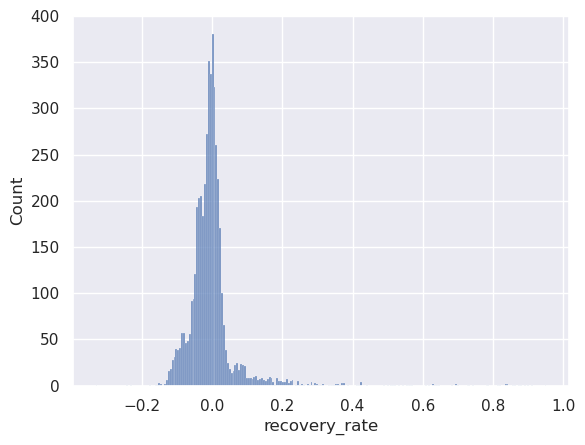

In [70]:
sns.histplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)


In [71]:
pickle.dump(reg_lgd_st_2, open('../data/lgd_model_stage_2.sav', 'wb'))

## LGD : Combine stage 1 + stage 2

In [72]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [73]:
y_hat_test_lgd_stage_2_all

array([0.10610923, 0.15761235, 0.09715261, ..., 0.14875221, 0.08835487,
       0.13009296])

In [74]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [75]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8495.000000
mean,0.078323
std,0.051882
min,-0.014771
25%,0.000000
50%,0.095527
75%,0.118824
max,0.205454


In [76]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

In [77]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8495.000000
mean,0.078326
std,0.051877
min,0.000000
25%,0.000000
50%,0.095527
75%,0.118824
max,0.205454


# EAD model

In [78]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

In [79]:
ead_inputs_train.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [80]:
ead_inputs_train = ead_inputs_train[features_all]
# Here we keep only the variables we need for the model.

In [81]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [82]:
reg_ead = LinearRegression()
# We create an instance of an object from the 'LogisticRegression' class.
reg_ead.fit(ead_inputs_train, ead_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

LinearRegression()

In [83]:
feature_name = ead_inputs_train.columns.values

In [84]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
p_values = reg_lgd_st_2.p
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = np.append(np.nan,np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.089334e+00,NaN
1,grade:A,-2.687641e-01,0.000000e+00
2,grade:B,-2.122175e-01,0.000000e+00
3,grade:C,-1.514182e-01,7.574830e-12
4,grade:D,-1.047741e-01,5.605774e-06
5,grade:E,-5.596866e-02,1.257209e-01
6,grade:F,-1.361975e-02,7.605310e-01
7,home_ownership:MORTGAGE,-5.201848e-03,1.114884e-02
8,home_ownership:NONE,-2.974480e-02,5.789385e-08
9,home_ownership:OTHER,3.777250e-02,8.314155e-01


## EAD : Model validation

In [85]:
ead_inputs_test = ead_inputs_test[features_all]
# Here we keep only the variables we need for the model.

In [86]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [87]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [88]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [89]:
ead_targets_test_temp = ead_targets_test

In [90]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [91]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,CCF,0
CCF,1.000000,0.537764
0,0.537764,1.000000


<Axes: xlabel='CCF', ylabel='Count'>

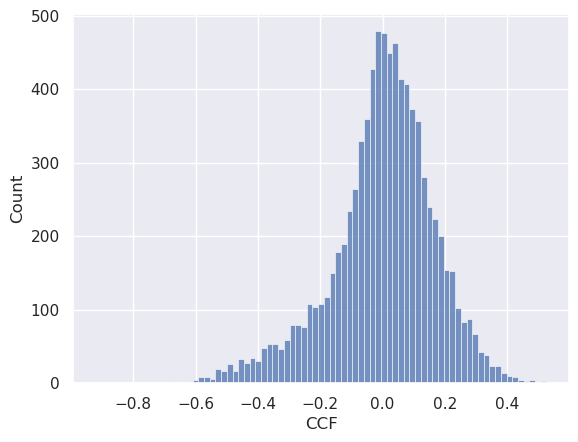

In [92]:
sns.histplot(ead_targets_test - y_hat_test_ead)
# We plot the distribution of the residuals.

In [93]:
pd.DataFrame(y_hat_test_ead).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8495.000000
mean,0.737178
std,0.106679
min,0.362317
25%,0.662338
50%,0.732477
75%,0.812484
max,0.996482


In [94]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [150]:
pd.DataFrame(y_hat_test_ead).describe()


,0
count,8495.000000
mean,0.737178
std,0.106679
min,0.362317
25%,0.662338
50%,0.732477
75%,0.812484
max,0.996482


# Expected Loss

In [95]:
loan_data_preprocessed.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,0,0,0,0,0,0,0,1,0,1
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,0,0,0,0,0,0,1,0,0
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,0,0,0,0,0,0,1,0,1
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,0,0,0,0,0,0,1,0,1
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,0,0,0,0,0,0,1,0,1


In [96]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
# We fill the missing values with zeroes.

/tmp/ipykernel_103534/3236500179.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)


In [97]:
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)
# We fill the missing values with zeroes.

/tmp/ipykernel_103534/3460898469.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)


In [98]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]
# Here we keep only the variables we need for the model.

In [99]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [100]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)
# We apply the stage 1 LGD model and calculate predicted values.

In [101]:
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)
# We apply the stage 2 LGD model and calculate predicted values.

In [102]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']
# We combine the predicted values from the stage 1 predicted model and the stage 2 predicted model
# to calculate the final estimated recovery rate.

In [103]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])
# We set estimated recovery rates that are greater than 1 to 1 and  estimated recovery rates that are less than 0 to 0.

In [104]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']
# We calculate estimated LGD. Estimated LGD equals 1 - estimated recovery rate.

In [105]:
loan_data_preprocessed['LGD'].describe()
# Shows some descriptive statisics for the values of a column.

count    466285.000000
mean          0.929682
std           0.057995
min           0.370269
25%           0.878671
50%           0.910148
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

In [106]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)
# We apply the EAD model to calculate estimated credit conversion factor.

In [107]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])
# We set estimated CCF that are greater than 1 to 1 and  estimated CCF that are less than 0 to 0.

In [108]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']
# We calculate estimated EAD. Estimated EAD equals estimated CCF multiplied by funded amount.

In [109]:
loan_data_preprocessed['EAD'].describe()
# Shows some descriptive statisics for the values of a column.

count    466285.000000
mean      10807.783465
std        6932.879958
min         179.525424
25%        5489.048712
50%        9206.648029
75%       14694.501758
max       35000.000000
Name: EAD, dtype: float64

In [110]:
loan_data_preprocessed.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,0,1,0,1,1,0.078856,0.078856,0.921144,0.578223,2891.112890
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,1,0,0,1,0.076744,0.076744,0.923256,0.774265,1935.662839
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,1,0,1,1,0.076405,0.076405,0.923595,0.653490,1568.375698
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,1,0,1,1,0.090202,0.090202,0.909798,0.652579,6525.789448
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,1,0,1,1,0.088010,0.088010,0.911990,0.710149,2130.445782


In [111]:
loan_data_inputs_train = pd.read_csv('../data/loan_data_inputs_train.csv')
# We import data to apply the PD model.

In [112]:
loan_data_inputs_test = pd.read_csv('../data/loan_data_inputs_test.csv')
# We import data to apply the PD model.

In [113]:
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
# We concatenate the two dataframes along the rows.

In [114]:
loan_data_inputs_pd.shape

(466285, 326)

In [115]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


In [116]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
# We set the index of the dataframe to the values of a specific column. 

In [118]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [119]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>=86']

In [120]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [121]:
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
# Here we keep only the variables we need for the model.

In [122]:
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)
# Here we remove the dummy variable reference categories.

In [123]:
loan_data_inputs_pd_temp.shape

(466285, 84)

In [124]:
import pickle

In [125]:
reg_pd = pickle.load(open('../data/pd_model.sav', 'rb'))
# We import the PD model, stored in the 'pd_model.sav' file.

In [126]:
reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
# We apply the PD model to caclulate estimated default probabilities.

array([0.02940394, 0.09139474, 0.03745395, ..., 0.02692721, 0.04022367,
       0.04793433])

In [127]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
# We apply the PD model to caclulate estimated default probabilities.

In [128]:
loan_data_inputs_pd['PD'].head()

Unnamed: 0
427211    0.029404
206088    0.091395
136020    0.037454
412305    0.201847
36159     0.208249
Name: PD, dtype: float64

In [129]:
loan_data_inputs_pd['PD'].describe()
# Shows some descriptive statisics for the values of a column.

count    466285.000000
mean          0.109299
std           0.070465
min           0.007434
25%           0.056238
50%           0.093496
75%           0.146718
max           0.550180
Name: PD, dtype: float64

In [130]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)
# We concatenate the dataframes where we calculated LGD and EAD and the dataframe where we calculated PD along the columns.

In [131]:
loan_data_preprocessed_new.shape

(466285, 540)

In [132]:
loan_data_preprocessed_new.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86,PD
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,1,0,1,0,0,0,0,0,0,0.163180
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,0,1,0,0,0,0,0,0,0.284240
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,0,1,0,0,0,0,0,0,0.211823
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,0,1,0,0,0,0,0,0,0.208379
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,0,1,0,0,0,0,0,0,0.130358


In [133]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']
# We calculate Expected Loss. EL = PD * LGD * EAD.

In [134]:
loan_data_preprocessed_new['EL'].describe()
# Shows some descriptive statisics for the values of a column.

count    466285.000000
mean       1090.686960
std        1104.882207
min           9.970561
25%         357.461469
50%         710.479501
75%        1418.862491
max       11633.144892
Name: EL, dtype: float64

In [135]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.163180,0.921144,2891.112890,434.570575
1,2500,2500,0.284240,0.923256,1935.662839,507.969142
2,2400,2400,0.211823,0.923595,1568.375698,306.835619
3,10000,10000,0.208379,0.909798,6525.789448,1237.175600
4,3000,3000,0.130358,0.911990,2130.445782,253.278819


In [136]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [137]:
loan_data_preprocessed_new['EL'].sum()
# Total Expected Loss for all loans.

508570969.36190265

In [138]:
loan_data_preprocessed_new['funded_amnt'].sum()
# Total funded amount for all loans.

funded_amnt    6664052450
funded_amnt    6664052450
dtype: int64

In [139]:
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()
# Total Expected Loss as a proportion of total funded amount for all loans.
####
####
####
# THE END.

funded_amnt    0.076316
funded_amnt    0.076316
dtype: float64